In [40]:
import pandas as pd 
import xml.etree.ElementTree as et 

xtree = et.parse("drivingtraining.tcx")
xroot = xtree.getroot() 

df_cols = ["time","latitude","longitude","distanceinmeters","heartrate"]
rows = []





In [41]:
xroot

<Element '{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}TrainingCenterDatabase' at 0x7ff732ca5ae0>

In [42]:
xroot[0][0][1].tag

'{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Lap'

Parses through tcx file to find relevant information and creates a pandas data fram

In [43]:
ctr=0
for lap in xroot[0][0].findall("{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Lap"):
    for node in lap[8].findall("{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Trackpoint"):
        if node[1].tag == "{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Position":
            time = node[0].text
            lat = node[1][0].text
            long = node[1][1].text
            dist= node[3].text
            bpm = node[4][0].text

            rows.append({"time": time, "latitude": lat, 
                            "longitude": long, "distanceinmeters": dist,
                            "heartrate":bpm})

    tracking_df = pd.DataFrame(rows, columns = df_cols)

In [44]:
tracking_df

,time,latitude,longitude,distanceinmeters,heartrate
0,2021-05-18T22:23:27.000Z,32.883947398513556,-117.13013364002109,0.0,65
1,2021-05-18T22:23:29.000Z,32.88394019007683,-117.13027152232826,12.930000305175781,65
2,2021-05-18T22:23:35.000Z,32.88390154950321,-117.13085079565644,67.33000183105469,65
3,2021-05-18T22:24:00.000Z,32.88386550731957,-117.13095154613256,80.58999633789062,68
4,2021-05-18T22:24:44.000Z,32.88386441767216,-117.13099035434425,84.11000061035156,68
...,...,...,...,...,...
286,2021-05-18T22:48:44.000Z,32.888480834662914,-117.13226314634085,10328.9404296875,72
287,2021-05-18T22:48:55.000Z,32.88886531256139,-117.13210648857057,10375.7001953125,76
288,2021-05-18T22:48:56.000Z,32.8888788074255,-117.13208746165037,10378.01953125,73
289,2021-05-18T22:48:59.000Z,32.888893224298954,-117.1320722065866,10380.1396484375,76


In [45]:
##formats the time
def time_splitter (row):
   datetime=row['time'].split("T")
   return datetime[1]
  

In [46]:
tracking_df["HHMMSS"]=tracking_df.apply (lambda row: time_splitter(row), axis=1)

In [47]:
tracking_df

,time,latitude,longitude,distanceinmeters,heartrate,HHMMSS
0,2021-05-18T22:23:27.000Z,32.883947398513556,-117.13013364002109,0.0,65,22:23:27.000Z
1,2021-05-18T22:23:29.000Z,32.88394019007683,-117.13027152232826,12.930000305175781,65,22:23:29.000Z
2,2021-05-18T22:23:35.000Z,32.88390154950321,-117.13085079565644,67.33000183105469,65,22:23:35.000Z
3,2021-05-18T22:24:00.000Z,32.88386550731957,-117.13095154613256,80.58999633789062,68,22:24:00.000Z
4,2021-05-18T22:24:44.000Z,32.88386441767216,-117.13099035434425,84.11000061035156,68,22:24:44.000Z
...,...,...,...,...,...,...
286,2021-05-18T22:48:44.000Z,32.888480834662914,-117.13226314634085,10328.9404296875,72,22:48:44.000Z
287,2021-05-18T22:48:55.000Z,32.88886531256139,-117.13210648857057,10375.7001953125,76,22:48:55.000Z
288,2021-05-18T22:48:56.000Z,32.8888788074255,-117.13208746165037,10378.01953125,73,22:48:56.000Z
289,2021-05-18T22:48:59.000Z,32.888893224298954,-117.1320722065866,10380.1396484375,76,22:48:59.000Z


In [48]:
tracking_df.distanceinmeters=tracking_df.distanceinmeters.astype(str).astype(float)

In [49]:
##creates a column of the difference of meters between two data points
meterscol=[]
for i,j in enumerate(tracking_df.distanceinmeters):
    meters=0
    if i>0:
        lastmet=tracking_df.distanceinmeters[i-1]
        met =j
        meters=met-lastmet
    meterscol.append(meters)


    

In [50]:
tracking_df["meters"]=meterscol

In [51]:
## creates a column of seconds between data points
secondscol=[]
for i,j in enumerate(tracking_df.HHMMSS):
    seconds=0
    if i>0:
        lastmins=int(tracking_df.HHMMSS[i-1][3:5])
        lastsecs=int(tracking_df.HHMMSS[i-1][6:8])
        mins=int(j[3:5])
        secs=int(j[6:8])
        if lastmins==mins:
            seconds=secs-lastsecs
        else:
            seconds = (60-lastsecs)+secs
    secondscol.append(seconds)


In [52]:
tracking_df["seconds"]=secondscol

In [53]:
## calculates milesperhour using meters and seconds
def calculate_speed(row):
    if (row.seconds>0):
        meterspersecond=row.meters/row.seconds
        milesperhour=meterspersecond*2.237
        return milesperhour
    else: return 0


In [54]:
tracking_df["mph"]=tracking_df.apply (lambda row: calculate_speed(row), axis=1)

In [55]:
## removes outliers, they are probably errors
tracking_df = tracking_df[tracking_df.mph < 85]

In [56]:
tracking_df

,time,latitude,longitude,distanceinmeters,heartrate,HHMMSS,meters,seconds,mph
0,2021-05-18T22:23:27.000Z,32.883947398513556,-117.13013364002109,0.000000,65,22:23:27.000Z,0.000000,0,0.000000
1,2021-05-18T22:23:29.000Z,32.88394019007683,-117.13027152232826,12.930000,65,22:23:29.000Z,12.930000,2,14.462205
2,2021-05-18T22:23:35.000Z,32.88390154950321,-117.13085079565644,67.330002,65,22:23:35.000Z,54.400002,6,20.282134
3,2021-05-18T22:24:00.000Z,32.88386550731957,-117.13095154613256,80.589996,68,22:24:00.000Z,13.259995,25,1.186504
4,2021-05-18T22:24:44.000Z,32.88386441767216,-117.13099035434425,84.110001,68,22:24:44.000Z,3.520004,44,0.178960
...,...,...,...,...,...,...,...,...,...
286,2021-05-18T22:48:44.000Z,32.888480834662914,-117.13226314634085,10328.940430,72,22:48:44.000Z,52.870117,9,13.141161
287,2021-05-18T22:48:55.000Z,32.88886531256139,-117.13210648857057,10375.700195,76,22:48:55.000Z,46.759766,11,9.509236
288,2021-05-18T22:48:56.000Z,32.8888788074255,-117.13208746165037,10378.019531,73,22:48:56.000Z,2.319336,1,5.188354
289,2021-05-18T22:48:59.000Z,32.888893224298954,-117.1320722065866,10380.139648,76,22:48:59.000Z,2.120117,3,1.580901


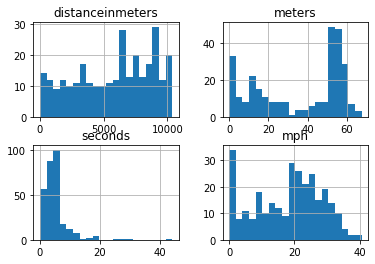

In [57]:
hist = tracking_df.hist(bins=20)

In [58]:
## creates csv out of finalized data frame
tracking_df.to_csv(r'training csv/drivingtraining.csv', index = False)